
Dataset:
4 training and 1 test
merging all and splitting into train and test
undersampling



##without contrastive learning

combined pits

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch [1/20], Loss: 0.9451
Epoch [2/20], Loss: 0.7050
Epoch [3/20], Loss: 0.5151
Epoch [4/20], Loss: 0.3598
Epoch [5/20], Loss: 0.2252
Epoch [6/20], Loss: 0.1308
Epoch [7/20], Loss: 0.0870
Epoch [8/20], Loss: 0.0594
Epoch [9/20], Loss: 0.0355
Epoch [10/20], Loss: 0.0714
Epoch [11/20], Loss: 0.0238
Epoch [12/20], Loss: 0.0708
Epoch [13/20], Loss: 0.0313
Epoch [14/20], Loss: 0.0200
Epoch [15/20], Loss: 0.0366
Epoch [16/20], Loss: 0.0118
Epoch [17/20], Loss: 0.0255
Epoch [18/20], Loss: 0.0101
Epoch [19/20], Loss: 0.0060
Epoch [20/20], Loss: 0.0564


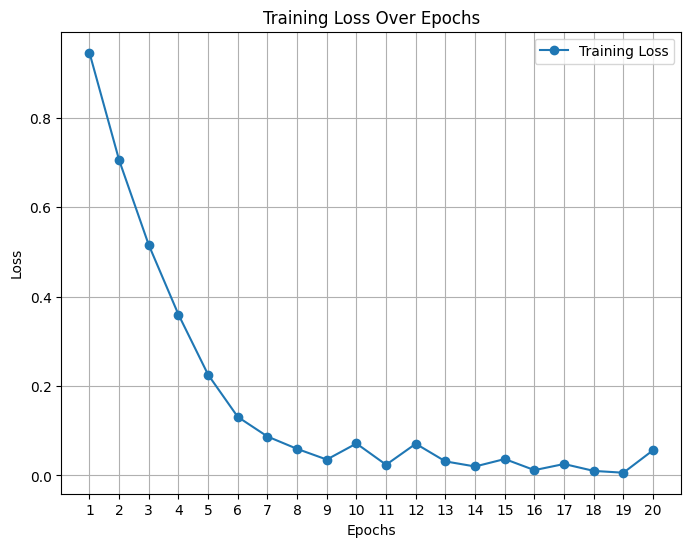

Test Accuracy: 0.7458
Precision: 0.7483
Recall: 0.7458
F1-Score: 0.7304


In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import nltk
import random
import numpy as np
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# Download NLTK stopwords if not already available
nltk.download('stopwords')

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load the dataset
file_path = '/content/combined_pits.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df = bug_report_df.fillna("")

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(
    descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Custom Dataset class to load bug report data
class BugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences within the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels = torch.stack(labels)  # Stack labels into a tensor

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

# CNN Classifier Model
class BugReportClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(BugReportClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embedding_dim))  # CNN layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(100, num_classes)  # Fully connected layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch_size, 1, seq_length, embedding_dim)
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Convolution + Activation + Pooling
        x = torch.mean(x, dim=2)  # Reduce sequence length dimension by averaging
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)  # Final classification layer
        return x

# Create train and test datasets and dataloaders
train_dataset = BugReportDataset(train_descriptions, train_labels, tokenizer)
test_dataset = BugReportDataset(test_descriptions, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model setup
embedding_dim = 768  # Embedding size of CodeBERT
cnn_model = BugReportClassifier(embedding_dim, num_classes).to(device)

# Include both CNN and CodeBERT in the optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(cnn_model.parameters()),
    lr=2e-5  # Lower learning rate for fine-tuning
)
criterion = nn.CrossEntropyLoss()

# Training loop
loss_values = []
for epoch in range(20):  # Number of epochs
    cnn_model.train()
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through CodeBERT to get embeddings
        outputs = model(input_ids=inputs, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state

        # Forward pass through CNN classifier
        cnn_outputs = cnn_model(embeddings)

        # Compute loss and backpropagate
        loss = criterion(cnn_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the training loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

# Function to evaluate the model on the test set
def evaluate_model(codebert_model, cnn_model, data_loader):
    cnn_model.eval()
    codebert_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass through CodeBERT to get embeddings
            outputs = codebert_model(input_ids=inputs, attention_mask=attention_masks)
            embeddings = outputs.last_hidden_state

            # Forward pass through CNN classifier
            cnn_outputs = cnn_model(embeddings)

            # Get the predicted class (highest probability)
            preds = torch.argmax(cnn_outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(model, cnn_model, test_loader)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Across different Pits

Epoch [1/10], Loss: 0.8871
Epoch [2/10], Loss: 0.6645
Epoch [3/10], Loss: 0.4762
Epoch [4/10], Loss: 0.2909
Epoch [5/10], Loss: 0.2234
Epoch [6/10], Loss: 0.1444
Epoch [7/10], Loss: 0.1245
Epoch [8/10], Loss: 0.0764
Epoch [9/10], Loss: 0.0520
Epoch [10/10], Loss: 0.0261
Epoch [11/10], Loss: 0.0169
Epoch [12/10], Loss: 0.0348
Epoch [13/10], Loss: 0.0397
Epoch [14/10], Loss: 0.0375
Epoch [15/10], Loss: 0.0477
Epoch [16/10], Loss: 0.0279
Epoch [17/10], Loss: 0.0091
Epoch [18/10], Loss: 0.0351
Epoch [19/10], Loss: 0.0395
Epoch [20/10], Loss: 0.0245


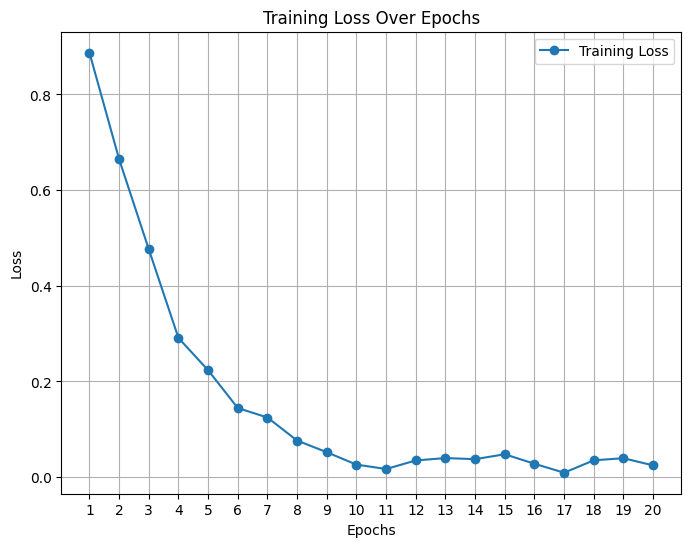

Test Accuracy: 0.3022
Precision: 0.9243
Recall: 0.3022
F1-Score: 0.3810


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import nltk
import random
import numpy as np
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# DatasetInfo class to encapsulate dataset information
class DatasetInfo:
    def __init__(self, path, project_id=None):
        self.path = path
        self.project_id = project_id


# Function to load datasets dynamically
def load_datasets(train_datasets, test_dataset):
    '''Loads and processes the datasets for training and testing.'''
    # Combine training datasets
    train_frames = [pd.read_csv(dataset.path).fillna("") for dataset in train_datasets]
    train_data = pd.concat(train_frames, ignore_index=True)

    # Load test dataset
    test_data = pd.read_csv(test_dataset.path).fillna("")

    # Convert severity labels to mapped values
    label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
    train_data['Severity'] = train_data['Severity'].astype(int).map(label_mapping)
    test_data['Severity'] = test_data['Severity'].astype(int).map(label_mapping)

    # Preprocess the 'Description' column
    train_data['processed_description'] = train_data['Description'].apply(preprocess_text)
    test_data['processed_description'] = test_data['Description'].apply(preprocess_text)

    # Extract descriptions and labels
    train_descriptions = train_data['processed_description'].tolist()
    test_descriptions = test_data['processed_description'].tolist()
    train_labels = train_data['Severity'].tolist()
    test_labels = test_data['Severity'].tolist()

    return train_descriptions, test_descriptions, train_labels, test_labels

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Specify datasets dynamically
# Specify datasets dynamically
train_datasets = [
    DatasetInfo('/content/pitsB.csv', project_id=1),
    DatasetInfo('/content/pitsC.csv', project_id=2),
    DatasetInfo('/content/pitsE.csv', project_id=2)

]
test_dataset = DatasetInfo('/content/pitsD.csv', project_id=3)

# Load data
train_descriptions, test_descriptions, train_labels, test_labels = load_datasets(train_datasets, test_dataset)
num_classes = len(set(train_labels))
# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Custom Dataset class to load bug report data
class BugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences within the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels = torch.stack(labels)  # Stack labels into a tensor

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

# CNN Classifier Model
class BugReportClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(BugReportClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embedding_dim))  # CNN layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(100, num_classes)  # Fully connected layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch_size, 1, seq_length, embedding_dim)
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Convolution + Activation + Pooling
        x = torch.mean(x, dim=2)  # Reduce sequence length dimension by averaging
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)  # Final classification layer
        return x

# Create train and test datasets and dataloaders
train_dataset = BugReportDataset(train_descriptions, train_labels, tokenizer)
test_dataset = BugReportDataset(test_descriptions, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model setup
embedding_dim = 768  # Embedding size of CodeBERT
cnn_model = BugReportClassifier(embedding_dim, num_classes).to(device)

# Include both CNN and CodeBERT in the optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(cnn_model.parameters()),
    lr=2e-5  # Lower learning rate for fine-tuning
)
criterion = nn.CrossEntropyLoss()

# Training loop
loss_values = []
for epoch in range(20):  # Number of epochs
    cnn_model.train()
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through CodeBERT to get embeddings
        outputs = model(input_ids=inputs, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state

        # Forward pass through CNN classifier
        cnn_outputs = cnn_model(embeddings)

        # Compute loss and backpropagate
        loss = criterion(cnn_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}")

# Plot the training loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

# Function to evaluate the model on the test set
def evaluate_model(codebert_model, cnn_model, data_loader):
    cnn_model.eval()
    codebert_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass through CodeBERT to get embeddings
            outputs = codebert_model(input_ids=inputs, attention_mask=attention_masks)
            embeddings = outputs.last_hidden_state

            # Forward pass through CNN classifier
            cnn_outputs = cnn_model(embeddings)

            # Get the predicted class (highest probability)
            preds = torch.argmax(cnn_outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(model, cnn_model, test_loader)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


##contrastive learning

combined_pits

Contrastive Epoch [1/20], Loss: 1.4027
Contrastive Epoch [2/20], Loss: 1.2145
Contrastive Epoch [3/20], Loss: 1.0605
Contrastive Epoch [4/20], Loss: 0.9511
Contrastive Epoch [5/20], Loss: 0.8682
Contrastive Epoch [6/20], Loss: 0.7976
Contrastive Epoch [7/20], Loss: 0.7419
Contrastive Epoch [8/20], Loss: 0.7010
Contrastive Epoch [9/20], Loss: 0.6634
Contrastive Epoch [10/20], Loss: 0.6445
Contrastive Epoch [11/20], Loss: 0.6195
Contrastive Epoch [12/20], Loss: 0.6030
Contrastive Epoch [13/20], Loss: 0.5857
Contrastive Epoch [14/20], Loss: 0.5770
Contrastive Epoch [15/20], Loss: 0.5622
Contrastive Epoch [16/20], Loss: 0.5448
Contrastive Epoch [17/20], Loss: 0.5520
Contrastive Epoch [18/20], Loss: 0.5437
Contrastive Epoch [19/20], Loss: 0.5346
Contrastive Epoch [20/20], Loss: 0.5327


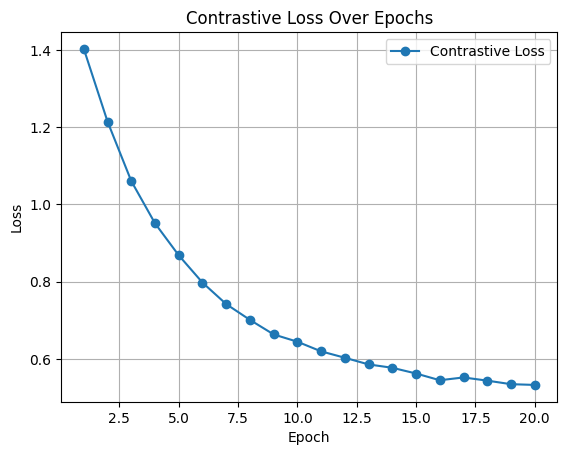

Classification Epoch [1/20], Loss: 0.4112
Classification Epoch [2/20], Loss: 0.1883
Classification Epoch [3/20], Loss: 0.1190
Classification Epoch [4/20], Loss: 0.0790
Classification Epoch [5/20], Loss: 0.0618
Classification Epoch [6/20], Loss: 0.0410
Classification Epoch [7/20], Loss: 0.0251
Classification Epoch [8/20], Loss: 0.0494
Classification Epoch [9/20], Loss: 0.0205
Classification Epoch [10/20], Loss: 0.0157
Classification Epoch [11/20], Loss: 0.0173
Classification Epoch [12/20], Loss: 0.0201
Classification Epoch [13/20], Loss: 0.0099
Classification Epoch [14/20], Loss: 0.0195
Classification Epoch [15/20], Loss: 0.0122
Classification Epoch [16/20], Loss: 0.0043
Classification Epoch [17/20], Loss: 0.0166
Classification Epoch [18/20], Loss: 0.0173
Classification Epoch [19/20], Loss: 0.0102
Classification Epoch [20/20], Loss: 0.0058


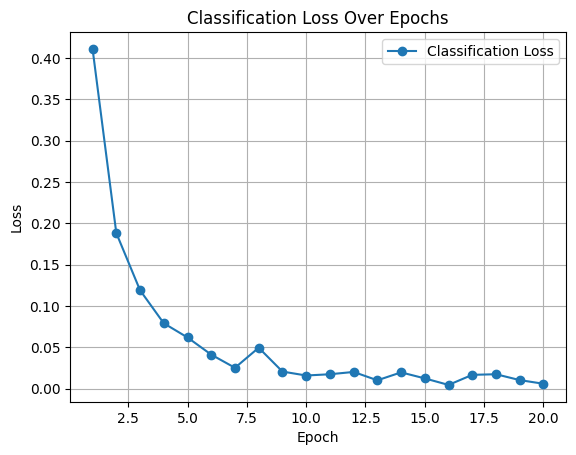

Test Accuracy: 0.7686
Precision: 0.7771
Recall: 0.7686
F1-Score: 0.7615


In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Load the dataset
file_path = '/content/combined_pits.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df['processed_description'] = bug_report_df['Description'].fillna("")

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))


# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(
    descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(20):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

#Across different Pits

Contrastive Epoch [1/20], Loss: 1.2719
Contrastive Epoch [2/20], Loss: 1.0185
Contrastive Epoch [3/20], Loss: 0.9609
Contrastive Epoch [4/20], Loss: 0.9066
Contrastive Epoch [5/20], Loss: 0.8683
Contrastive Epoch [6/20], Loss: 0.8398
Contrastive Epoch [7/20], Loss: 0.7927
Contrastive Epoch [8/20], Loss: 0.7532
Contrastive Epoch [9/20], Loss: 0.7367
Contrastive Epoch [10/20], Loss: 0.7084
Contrastive Epoch [11/20], Loss: 0.6811
Contrastive Epoch [12/20], Loss: 0.6656
Contrastive Epoch [13/20], Loss: 0.6460
Contrastive Epoch [14/20], Loss: 0.6273
Contrastive Epoch [15/20], Loss: 0.6122
Contrastive Epoch [16/20], Loss: 0.5932
Contrastive Epoch [17/20], Loss: 0.5923
Contrastive Epoch [18/20], Loss: 0.5733
Contrastive Epoch [19/20], Loss: 0.5658
Contrastive Epoch [20/20], Loss: 0.5549


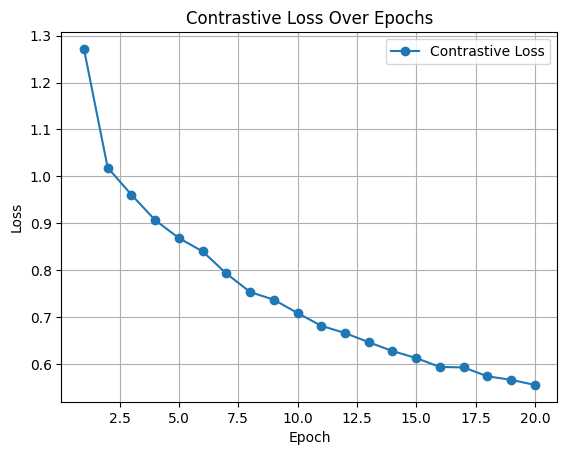

Classification Epoch [1/20], Loss: 0.7321
Classification Epoch [2/20], Loss: 0.4239
Classification Epoch [3/20], Loss: 0.2722
Classification Epoch [4/20], Loss: 0.1839
Classification Epoch [5/20], Loss: 0.1180
Classification Epoch [6/20], Loss: 0.0835
Classification Epoch [7/20], Loss: 0.0656
Classification Epoch [8/20], Loss: 0.0322
Classification Epoch [9/20], Loss: 0.0479
Classification Epoch [10/20], Loss: 0.0502
Classification Epoch [11/20], Loss: 0.0426
Classification Epoch [12/20], Loss: 0.0415
Classification Epoch [13/20], Loss: 0.0210
Classification Epoch [14/20], Loss: 0.0201
Classification Epoch [15/20], Loss: 0.0090
Classification Epoch [16/20], Loss: 0.0251
Classification Epoch [17/20], Loss: 0.0140
Classification Epoch [18/20], Loss: 0.0199
Classification Epoch [19/20], Loss: 0.0427
Classification Epoch [20/20], Loss: 0.0156


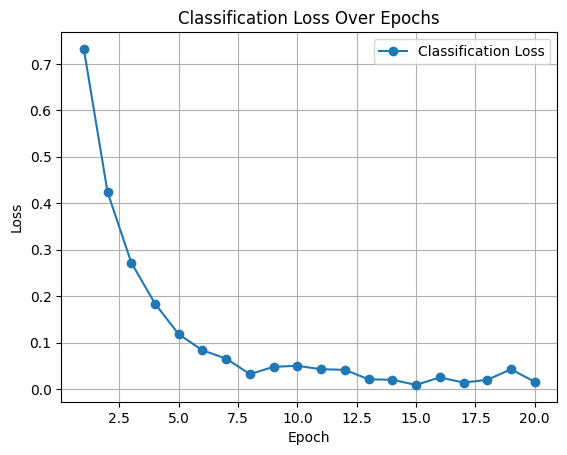

Test Accuracy: 0.5103
Precision: 0.5165
Recall: 0.5103
F1-Score: 0.5098


In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# DatasetInfo class to encapsulate dataset information
class DatasetInfo:
    def __init__(self, path, project_id=None):
        self.path = path
        self.project_id = project_id


# Function to load datasets dynamically
def load_datasets(train_datasets, test_dataset):
    '''Loads and processes the datasets for training and testing.'''
    # Combine training datasets
    train_frames = [pd.read_csv(dataset.path).fillna("") for dataset in train_datasets]
    train_data = pd.concat(train_frames, ignore_index=True)

    # Load test dataset
    test_data = pd.read_csv(test_dataset.path).fillna("")

    # Convert severity labels to mapped values
    label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
    train_data['Severity'] = train_data['Severity'].astype(int).map(label_mapping)
    test_data['Severity'] = test_data['Severity'].astype(int).map(label_mapping)

    # Preprocess the 'Description' column
    train_data['processed_description'] = train_data['Description'].apply(preprocess_text)
    test_data['processed_description'] = test_data['Description'].apply(preprocess_text)

    # Extract descriptions and labels
    train_descriptions = train_data['processed_description'].tolist()
    test_descriptions = test_data['processed_description'].tolist()
    train_labels = train_data['Severity'].tolist()
    test_labels = test_data['Severity'].tolist()

    return train_descriptions, test_descriptions, train_labels, test_labels

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Specify datasets dynamically
# Specify datasets dynamically
train_datasets = [
    DatasetInfo('/content/pitsA.csv', project_id=1),
    DatasetInfo('/content/pitsB.csv', project_id=2),
    DatasetInfo('/content/pitsC.csv', project_id=3),
    DatasetInfo('/content/pitsD.csv', project_id=4)
]
test_dataset = DatasetInfo('/content/pitsE.csv', project_id=5)

# Load data
train_descriptions, test_descriptions, train_labels, test_labels = load_datasets(train_datasets, test_dataset)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(20):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

with subject

Contrastive Epoch [1/20], Loss: 1.2223
Contrastive Epoch [2/20], Loss: 1.0091
Contrastive Epoch [3/20], Loss: 0.9383
Contrastive Epoch [4/20], Loss: 0.8870
Contrastive Epoch [5/20], Loss: 0.8512
Contrastive Epoch [6/20], Loss: 0.8128
Contrastive Epoch [7/20], Loss: 0.7788
Contrastive Epoch [8/20], Loss: 0.7653
Contrastive Epoch [9/20], Loss: 0.7372
Contrastive Epoch [10/20], Loss: 0.7157
Contrastive Epoch [11/20], Loss: 0.6952
Contrastive Epoch [12/20], Loss: 0.6759
Contrastive Epoch [13/20], Loss: 0.6650
Contrastive Epoch [14/20], Loss: 0.6517
Contrastive Epoch [15/20], Loss: 0.6379
Contrastive Epoch [16/20], Loss: 0.6205
Contrastive Epoch [17/20], Loss: 0.6088
Contrastive Epoch [18/20], Loss: 0.5976
Contrastive Epoch [19/20], Loss: 0.5871
Contrastive Epoch [20/20], Loss: 0.5800


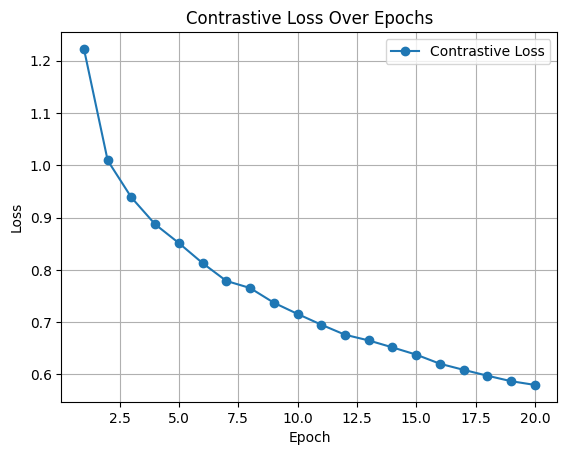

Classification Epoch [1/20], Loss: 0.5609
Classification Epoch [2/20], Loss: 0.3068
Classification Epoch [3/20], Loss: 0.2261
Classification Epoch [4/20], Loss: 0.1622
Classification Epoch [5/20], Loss: 0.1323
Classification Epoch [6/20], Loss: 0.1206
Classification Epoch [7/20], Loss: 0.0841
Classification Epoch [8/20], Loss: 0.0758
Classification Epoch [9/20], Loss: 0.0657
Classification Epoch [10/20], Loss: 0.0514
Classification Epoch [11/20], Loss: 0.0555
Classification Epoch [12/20], Loss: 0.0488
Classification Epoch [13/20], Loss: 0.0489
Classification Epoch [14/20], Loss: 0.0416
Classification Epoch [15/20], Loss: 0.0322
Classification Epoch [16/20], Loss: 0.0296
Classification Epoch [17/20], Loss: 0.0457
Classification Epoch [18/20], Loss: 0.0299
Classification Epoch [19/20], Loss: 0.0184
Classification Epoch [20/20], Loss: 0.0128


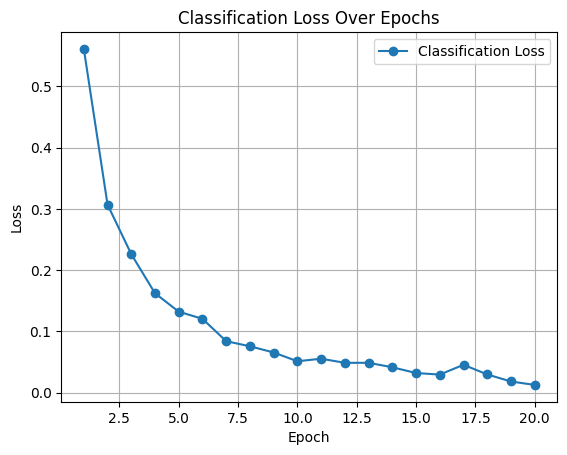

Test Accuracy: 0.5636
Precision: 0.5470
Recall: 0.5636
F1-Score: 0.5490


In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# DatasetInfo class to encapsulate dataset information
class DatasetInfo:
    def __init__(self, path, project_id=None):
        self.path = path
        self.project_id = project_id


# Function to load datasets dynamically
def load_datasets(train_datasets, test_dataset):
    '''Loads and processes the datasets for training and testing.'''
    # Combine training datasets
    train_frames = [pd.read_csv(dataset.path).fillna("") for dataset in train_datasets]
    train_data = pd.concat(train_frames, ignore_index=True)

    # Load test dataset
    test_data = pd.read_csv(test_dataset.path).fillna("")

    # Convert severity labels to mapped values
    label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
    train_data['Severity'] = train_data['Severity'].astype(int).map(label_mapping)
    test_data['Severity'] = test_data['Severity'].astype(int).map(label_mapping)

    # Preprocess the 'Description' column
    train_data['processed_description'] = train_data['Subject'].apply(preprocess_text)
    test_data['processed_description'] = test_data['Subject'].apply(preprocess_text)

    # Extract descriptions and labels
    train_descriptions = train_data['processed_description'].tolist()
    test_descriptions = test_data['processed_description'].tolist()
    train_labels = train_data['Severity'].tolist()
    test_labels = test_data['Severity'].tolist()

    return train_descriptions, test_descriptions, train_labels, test_labels

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Specify datasets dynamically
# Specify datasets dynamically
train_datasets = [
    DatasetInfo('/content/pitsA.csv', project_id=1),
    DatasetInfo('/content/pitsB.csv', project_id=2),
    DatasetInfo('/content/pitsC.csv', project_id=3),
    DatasetInfo('/content/pitsD.csv', project_id=4)
]
test_dataset = DatasetInfo('/content/pitsE.csv', project_id=5)

# Load data
train_descriptions, test_descriptions, train_labels, test_labels = load_datasets(train_datasets, test_dataset)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(20):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Contrastive Epoch [1/20], Loss: 1.3182
Contrastive Epoch [2/20], Loss: 1.0607
Contrastive Epoch [3/20], Loss: 0.9696
Contrastive Epoch [4/20], Loss: 0.9098
Contrastive Epoch [5/20], Loss: 0.8667
Contrastive Epoch [6/20], Loss: 0.8070
Contrastive Epoch [7/20], Loss: 0.7654
Contrastive Epoch [8/20], Loss: 0.7426
Contrastive Epoch [9/20], Loss: 0.7203
Contrastive Epoch [10/20], Loss: 0.6880
Contrastive Epoch [11/20], Loss: 0.6660
Contrastive Epoch [12/20], Loss: 0.6594
Contrastive Epoch [13/20], Loss: 0.6373
Contrastive Epoch [14/20], Loss: 0.6229
Contrastive Epoch [15/20], Loss: 0.6037
Contrastive Epoch [16/20], Loss: 0.5926
Contrastive Epoch [17/20], Loss: 0.5856
Contrastive Epoch [18/20], Loss: 0.5711
Contrastive Epoch [19/20], Loss: 0.5625
Contrastive Epoch [20/20], Loss: 0.5545


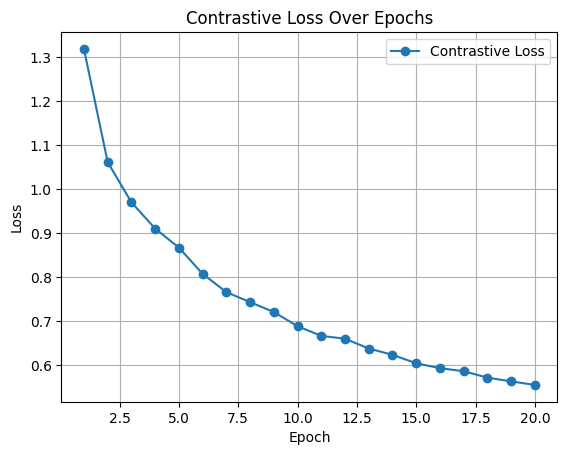

Classification Epoch [1/20], Loss: 0.7400
Classification Epoch [2/20], Loss: 0.5033
Classification Epoch [3/20], Loss: 0.3154
Classification Epoch [4/20], Loss: 0.2064
Classification Epoch [5/20], Loss: 0.1331
Classification Epoch [6/20], Loss: 0.1000
Classification Epoch [7/20], Loss: 0.0777
Classification Epoch [8/20], Loss: 0.0549
Classification Epoch [9/20], Loss: 0.0429
Classification Epoch [10/20], Loss: 0.0354
Classification Epoch [11/20], Loss: 0.0381
Classification Epoch [12/20], Loss: 0.0500
Classification Epoch [13/20], Loss: 0.0174
Classification Epoch [14/20], Loss: 0.0202
Classification Epoch [15/20], Loss: 0.0438
Classification Epoch [16/20], Loss: 0.0506
Classification Epoch [17/20], Loss: 0.0267
Classification Epoch [18/20], Loss: 0.0390
Classification Epoch [19/20], Loss: 0.0241
Classification Epoch [20/20], Loss: 0.0108


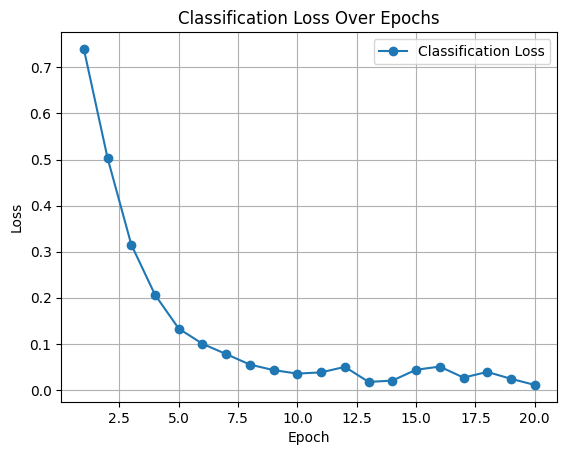

Test Accuracy: 0.6347
Precision: 0.6916
Recall: 0.6347
F1-Score: 0.6166


In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# DatasetInfo class to encapsulate dataset information
class DatasetInfo:
    def __init__(self, path, project_id=None):
        self.path = path
        self.project_id = project_id


# Function to load datasets dynamically
def load_datasets(train_datasets, test_dataset):
    '''Loads and processes the datasets for training and testing.'''
    # Combine training datasets
    train_frames = [pd.read_csv(dataset.path).fillna("") for dataset in train_datasets]
    train_data = pd.concat(train_frames, ignore_index=True)

    # Load test dataset
    test_data = pd.read_csv(test_dataset.path).fillna("")

    # Convert severity labels to mapped values
    label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
    train_data['Severity'] = train_data['Severity'].astype(int).map(label_mapping)
    test_data['Severity'] = test_data['Severity'].astype(int).map(label_mapping)

    # Preprocess the 'Description' column
    train_data['processed_description'] = train_data['Description'].apply(preprocess_text)
    test_data['processed_description'] = test_data['Description'].apply(preprocess_text)

    # Extract descriptions and labels
    train_descriptions = train_data['processed_description'].tolist()
    test_descriptions = test_data['processed_description'].tolist()
    train_labels = train_data['Severity'].tolist()
    test_labels = test_data['Severity'].tolist()

    return train_descriptions, test_descriptions, train_labels, test_labels

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Specify datasets dynamically
# Specify datasets dynamically
train_datasets = [
    DatasetInfo('/content/pitsA.csv', project_id=1),
    DatasetInfo('/content/pitsB.csv', project_id=2)

]
test_dataset = DatasetInfo('/content/pitsC.csv', project_id=2)

# Load data
train_descriptions, test_descriptions, train_labels, test_labels = load_datasets(train_datasets, test_dataset)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(20):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

with project id included

A, B, C, D - E

Contrastive Epoch [1/20], Loss: 1.1092
Contrastive Epoch [2/20], Loss: 0.9674
Contrastive Epoch [3/20], Loss: 0.9102
Contrastive Epoch [4/20], Loss: 0.8537
Contrastive Epoch [5/20], Loss: 0.8060


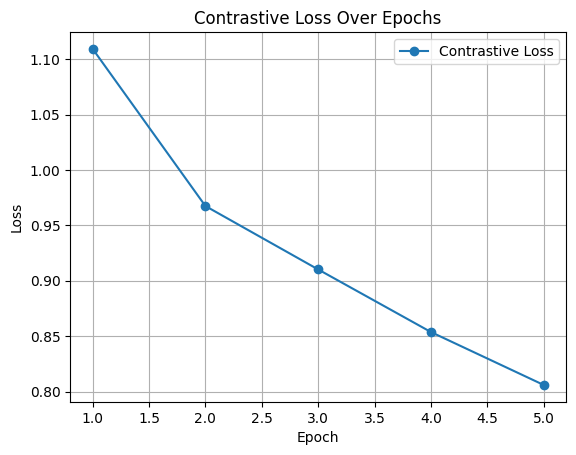

Classification Epoch [1/20], Loss: 0.7231
Classification Epoch [2/20], Loss: 0.4615
Classification Epoch [3/20], Loss: 0.2991
Classification Epoch [4/20], Loss: 0.1595
Classification Epoch [5/20], Loss: 0.0970


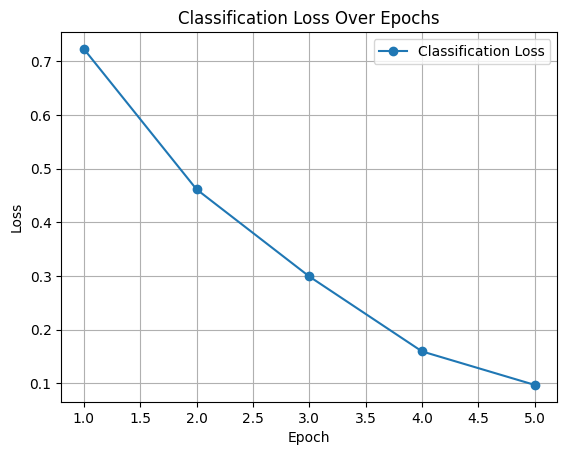

Test Accuracy: 0.5806
Precision: 0.5266
Recall: 0.5806
F1-Score: 0.5471


In [10]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# DatasetInfo class to encapsulate dataset information
class DatasetInfo:
    def __init__(self, path, project_id=None):
        self.path = path
        self.project_id = project_id

# Function to load datasets dynamically
def load_datasets(train_datasets, test_dataset):
    '''Loads and processes the datasets for training and testing.'''
    # Combine training datasets
    train_frames = []
    for dataset in train_datasets:
        df = pd.read_csv(dataset.path).fillna("")
        df['Project_ID'] = dataset.project_id  # Add Project_ID column
        train_frames.append(df)
    train_data = pd.concat(train_frames, ignore_index=True)

    # Load test dataset
    test_data = pd.read_csv(test_dataset.path).fillna("")
    test_data['Project_ID'] = test_dataset.project_id  # Add Project_ID column

    # Convert severity labels to mapped values
    label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
    train_data['Severity'] = train_data['Severity'].astype(int).map(label_mapping)
    test_data['Severity'] = test_data['Severity'].astype(int).map(label_mapping)

    # Preprocess the 'Description' column
    train_data['processed_description'] = train_data['Description'].apply(preprocess_text)
    test_data['processed_description'] = test_data['Description'].apply(preprocess_text)

    # Extract descriptions, labels, and project IDs
    train_descriptions = train_data['processed_description'].tolist()
    test_descriptions = test_data['processed_description'].tolist()
    train_labels = train_data['Severity'].tolist()
    test_labels = test_data['Severity'].tolist()
    train_project_ids = train_data['Project_ID'].tolist()
    test_project_ids = test_data['Project_ID'].tolist()

    return train_descriptions, test_descriptions, train_labels, test_labels, train_project_ids, test_project_ids

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Specify datasets dynamically
train_datasets = [
    DatasetInfo('/content/pitsA.csv', project_id=1),
    DatasetInfo('/content/pitsB.csv', project_id=2),
    DatasetInfo('/content/pitsC.csv', project_id=3),
    DatasetInfo('/content/pitsD.csv', project_id=4),
]
test_dataset = DatasetInfo('/content/pitsE.csv', project_id=5)

# Load data
train_descriptions, test_descriptions, train_labels, test_labels, train_project_ids, test_project_ids = load_datasets(train_datasets, test_dataset)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, project_ids, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.project_ids = project_ids
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append((self.descriptions[idx], self.project_ids[idx]))

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((*group[i], *group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((*group[i], *neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, proj_id1, desc2, proj_id2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'project_id_1': proj_id1,
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'project_id_2': proj_id2,
            'label': torch.tensor(label, dtype=torch.float)
        }

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    project_ids_1 = [item['project_id_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    project_ids_2 = [item['project_id_2'] for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'project_id_1': torch.tensor(project_ids_1, dtype=torch.long),
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'project_id_2': torch.tensor(project_ids_2, dtype=torch.long),
        'label': labels_tensor
    }

# Add project embeddings to the model
class CodeBERTWithContrastive(nn.Module):
    def __init__(self, model, project_embedding_dim=32):
        super(CodeBERTWithContrastive, self).__init__()
        self.codebert = model
        self.project_embedding = nn.Embedding(10, project_embedding_dim)  # Assume max 10 projects
        self.fc = nn.Linear(model.config.hidden_size + project_embedding_dim, 128)

    def forward(self, input_ids, attention_mask, project_ids):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # CLS token
        project_emb = self.project_embedding(project_ids)
        combined = torch.cat((pooled_output, project_emb), dim=1)
        return self.fc(combined)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
contrastive_model = CodeBERTWithContrastive(model).to(device)

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Training loop with contrastive loss
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, train_project_ids, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn
)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(10):
    contrastive_model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        project_id_1 = batch['project_id_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        project_id_2 = batch['project_id_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        embeddings_1 = contrastive_model(input_ids_1, attention_mask_1, project_id_1)
        embeddings_2 = contrastive_model(input_ids_2, attention_mask_2, project_id_2)

        loss = contrastive_loss_fn(embeddings_1, embeddings_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch + 1}/20], Loss: {epoch_loss:.4f}")

# Plot contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, project_ids, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.project_ids = project_ids
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        project_id = self.project_ids[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        inputs['project_id'] = torch.tensor(project_id, dtype=torch.long)
        return inputs

# Custom collate function for classification with padding
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    project_ids = [item['project_id'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad sequences to the same length
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.long)
    project_ids_tensor = torch.tensor(project_ids, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'project_id': project_ids_tensor,
        'label': labels_tensor
    }
# Classification DataLoaders
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, train_project_ids, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, test_project_ids, tokenizer)

# Classification DataLoaders with fixed collate function
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)
# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes, project_embedding_dim=32):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.project_embedding = nn.Embedding(10, project_embedding_dim)  # Assume max 10 projects
        self.classification_head = nn.Linear(model.config.hidden_size + project_embedding_dim, num_classes)

    def forward(self, input_ids, attention_mask, project_ids):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # CLS token representation
        project_emb = self.project_embedding(project_ids)
        combined = torch.cat((pooled_output, project_emb), dim=1)
        logits = self.classification_head(combined)
        return logits

# Initialize the classification model
num_classes = len(set(train_labels))
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(10):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        project_ids = batch['project_id'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask, project_ids)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch + 1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask = batch['attention_mask'].squeeze(1).to(device)
            project_ids = batch['project_id'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask, project_ids)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


A, B - C

Contrastive Epoch [1/20], Loss: 1.1384
Contrastive Epoch [2/20], Loss: 0.9801
Contrastive Epoch [3/20], Loss: 0.9128
Contrastive Epoch [4/20], Loss: 0.8519
Contrastive Epoch [5/20], Loss: 0.7997


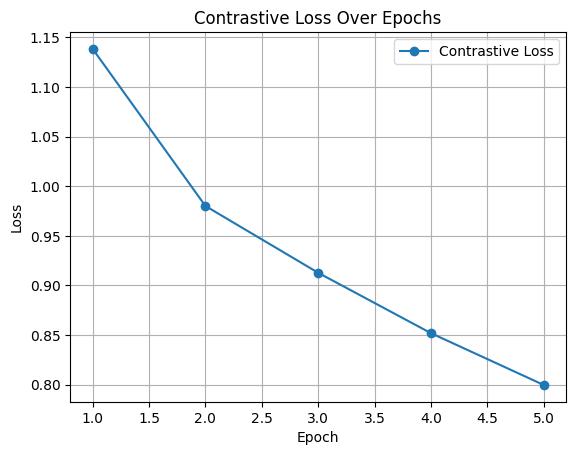

Classification Epoch [1/20], Loss: 0.8221
Classification Epoch [2/20], Loss: 0.5675
Classification Epoch [3/20], Loss: 0.3796
Classification Epoch [4/20], Loss: 0.2309
Classification Epoch [5/20], Loss: 0.1099


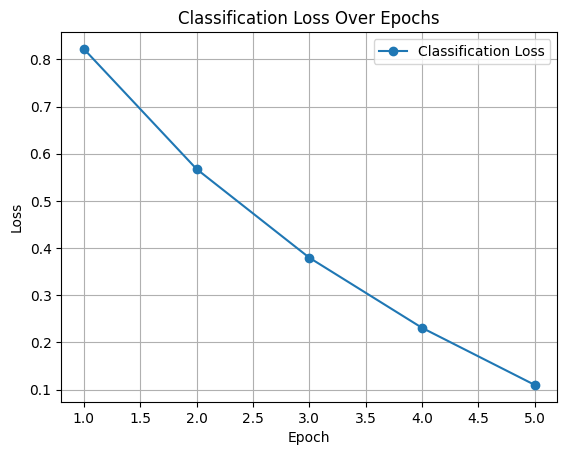

Test Accuracy: 0.6780
Precision: 0.6816
Recall: 0.6780
F1-Score: 0.6709


In [11]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# DatasetInfo class to encapsulate dataset information
class DatasetInfo:
    def __init__(self, path, project_id=None):
        self.path = path
        self.project_id = project_id

# Function to load datasets dynamically
def load_datasets(train_datasets, test_dataset):
    '''Loads and processes the datasets for training and testing.'''
    # Combine training datasets
    train_frames = []
    for dataset in train_datasets:
        df = pd.read_csv(dataset.path).fillna("")
        df['Project_ID'] = dataset.project_id  # Add Project_ID column
        train_frames.append(df)
    train_data = pd.concat(train_frames, ignore_index=True)

    # Load test dataset
    test_data = pd.read_csv(test_dataset.path).fillna("")
    test_data['Project_ID'] = test_dataset.project_id  # Add Project_ID column

    # Convert severity labels to mapped values
    label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
    train_data['Severity'] = train_data['Severity'].astype(int).map(label_mapping)
    test_data['Severity'] = test_data['Severity'].astype(int).map(label_mapping)

    # Preprocess the 'Description' column
    train_data['processed_description'] = train_data['Description'].apply(preprocess_text)
    test_data['processed_description'] = test_data['Description'].apply(preprocess_text)

    # Extract descriptions, labels, and project IDs
    train_descriptions = train_data['processed_description'].tolist()
    test_descriptions = test_data['processed_description'].tolist()
    train_labels = train_data['Severity'].tolist()
    test_labels = test_data['Severity'].tolist()
    train_project_ids = train_data['Project_ID'].tolist()
    test_project_ids = test_data['Project_ID'].tolist()

    return train_descriptions, test_descriptions, train_labels, test_labels, train_project_ids, test_project_ids

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Specify datasets dynamically
train_datasets = [
    DatasetInfo('/content/pitsA.csv', project_id=1),
    DatasetInfo('/content/pitsB.csv', project_id=2)
]
test_dataset = DatasetInfo('/content/pitsC.csv', project_id=3)

# Load data
train_descriptions, test_descriptions, train_labels, test_labels, train_project_ids, test_project_ids = load_datasets(train_datasets, test_dataset)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, project_ids, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.project_ids = project_ids
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append((self.descriptions[idx], self.project_ids[idx]))

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((*group[i], *group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((*group[i], *neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, proj_id1, desc2, proj_id2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'project_id_1': proj_id1,
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'project_id_2': proj_id2,
            'label': torch.tensor(label, dtype=torch.float)
        }

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    project_ids_1 = [item['project_id_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    project_ids_2 = [item['project_id_2'] for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'project_id_1': torch.tensor(project_ids_1, dtype=torch.long),
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'project_id_2': torch.tensor(project_ids_2, dtype=torch.long),
        'label': labels_tensor
    }

# Add project embeddings to the model
class CodeBERTWithContrastive(nn.Module):
    def __init__(self, model, project_embedding_dim=32):
        super(CodeBERTWithContrastive, self).__init__()
        self.codebert = model
        self.project_embedding = nn.Embedding(10, project_embedding_dim)  # Assume max 10 projects
        self.fc = nn.Linear(model.config.hidden_size + project_embedding_dim, 128)

    def forward(self, input_ids, attention_mask, project_ids):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # CLS token
        project_emb = self.project_embedding(project_ids)
        combined = torch.cat((pooled_output, project_emb), dim=1)
        return self.fc(combined)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Initialize model
contrastive_model = CodeBERTWithContrastive(model).to(device)

# Training loop with contrastive loss
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, train_project_ids, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn
)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(5):
    contrastive_model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        project_id_1 = batch['project_id_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        project_id_2 = batch['project_id_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        embeddings_1 = contrastive_model(input_ids_1, attention_mask_1, project_id_1)
        embeddings_2 = contrastive_model(input_ids_2, attention_mask_2, project_id_2)

        loss = contrastive_loss_fn(embeddings_1, embeddings_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch + 1}/20], Loss: {epoch_loss:.4f}")

# Plot contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, project_ids, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.project_ids = project_ids
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        project_id = self.project_ids[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        inputs['project_id'] = torch.tensor(project_id, dtype=torch.long)
        return inputs

# Custom collate function for classification with padding
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    project_ids = [item['project_id'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad sequences to the same length
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.long)
    project_ids_tensor = torch.tensor(project_ids, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'project_id': project_ids_tensor,
        'label': labels_tensor
    }
# Classification DataLoaders
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, train_project_ids, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, test_project_ids, tokenizer)

# Classification DataLoaders with fixed collate function
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)
# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes, project_embedding_dim=32):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.project_embedding = nn.Embedding(10, project_embedding_dim)  # Assume max 10 projects
        self.classification_head = nn.Linear(model.config.hidden_size + project_embedding_dim, num_classes)

    def forward(self, input_ids, attention_mask, project_ids):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # CLS token representation
        project_emb = self.project_embedding(project_ids)
        combined = torch.cat((pooled_output, project_emb), dim=1)
        logits = self.classification_head(combined)
        return logits

# Initialize the classification model
num_classes = len(set(train_labels))
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(5):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        project_ids = batch['project_id'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask, project_ids)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch + 1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask = batch['attention_mask'].squeeze(1).to(device)
            project_ids = batch['project_id'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask, project_ids)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


with regularization faster

In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import nltk
import random
import numpy as np
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence

# Download NLTK stopwords if not already available
nltk.download('stopwords')

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load the dataset
file_path = '/content/combined_pits.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df = bug_report_df.fillna("")

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(
    descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Custom Dataset class
class BugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function
def collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['labels'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.stack(labels)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

# CNN Classifier Model
class BugReportClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(BugReportClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embedding_dim))  # CNN layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.dropout = nn.Dropout(p=0.3)  # Add dropout
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = torch.mean(x, dim=2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        return x

# Create train and test datasets and dataloaders
train_dataset = BugReportDataset(train_descriptions, train_labels, tokenizer)
test_dataset = BugReportDataset(test_descriptions, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = BugReportClassifier(embedding_dim=768, num_classes=4).to(device)
model = model.to(device)  # Move CodeBERT to the same device

# Define loss and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
for epoch in range(30):  # Number of epochs
    cnn_model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch['input_ids'].to(device)  # Move inputs to the correct device
        attention_masks = batch['attention_mask'].to(device)  # Move masks to the correct device
        labels = batch['labels'].to(device)  # Move labels to the correct device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through CodeBERT to get embeddings
        with torch.no_grad():
            outputs = model(input_ids=inputs, attention_mask=attention_masks)
            embeddings = outputs.last_hidden_state.to(device)  # Ensure embeddings are on the same device

        # Forward pass through CNN classifier
        cnn_outputs = cnn_model(embeddings)

        # Compute loss and backpropagate
        loss = criterion(cnn_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
def evaluate_model(codebert_model, cnn_model, data_loader):
    cnn_model.eval()
    codebert_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)  # Move inputs to the correct device
            attention_masks = batch['attention_mask'].to(device)  # Move masks to the correct device
            labels = batch['labels'].to(device)  # Move labels to the correct device

            outputs = codebert_model(input_ids=inputs, attention_mask=attention_masks)
            embeddings = outputs.last_hidden_state.to(device)  # Ensure embeddings are on the correct device
            cnn_outputs = cnn_model(embeddings)

            preds = torch.argmax(cnn_outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

    return all_preds, all_labels

# Test model and calculate metrics
test_preds, test_labels = evaluate_model(model, cnn_model, test_loader)
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch [1/30], Loss: 1.0672
Epoch [2/30], Loss: 0.9773
Epoch [3/30], Loss: 0.9274
Epoch [4/30], Loss: 0.8986
Epoch [5/30], Loss: 0.8789
Epoch [6/30], Loss: 0.8626
Epoch [7/30], Loss: 0.8397
Epoch [8/30], Loss: 0.8327
Epoch [9/30], Loss: 0.8163
Epoch [10/30], Loss: 0.8125
Epoch [11/30], Loss: 0.8095
Epoch [12/30], Loss: 0.8087
Epoch [13/30], Loss: 0.7923
Epoch [14/30], Loss: 0.7781
Epoch [15/30], Loss: 0.7750
Epoch [16/30], Loss: 0.7640
Epoch [17/30], Loss: 0.7561
Epoch [18/30], Loss: 0.7470
Epoch [19/30], Loss: 0.7350
Epoch [20/30], Loss: 0.7319
Epoch [21/30], Loss: 0.7321
Epoch [22/30], Loss: 0.7219
Epoch [23/30], Loss: 0.7077
Epoch [24/30], Loss: 0.6983
Epoch [25/30], Loss: 0.6880
Epoch [26/30], Loss: 0.6855
Epoch [27/30], Loss: 0.6964
Epoch [28/30], Loss: 0.6819
Epoch [29/30], Loss: 0.6585
Epoch [30/30], Loss: 0.6696
Test Accuracy: 0.6849
Precision: 0.6753
Recall: 0.6849
F1-Score: 0.6677
